In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [2]:
vehiculo = 'DA01'

In [3]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

314

In [4]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [5]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [6]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

9

In [7]:
contenido_filtrado

['2025-10-23 20-40-14.tlog',
 '2025-10-23 22-23-06.tlog',
 '2025-10-23 23-58-21.tlog',
 '2025-10-23 23-58-59.tlog',
 '2025-10-23 23-59-55.tlog',
 '2025-10-24 01-28-49.tlog',
 '2025-10-24 01-53-59.tlog',
 '2025-10-24 02-20-00.tlog',
 '2025-10-24 02-54-55.tlog']

In [8]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [9]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (-62.787 -17.254, -62.787 -17.254, -62.787 -17.254, -62.787 -17....>,
 <LINESTRING (-62.787 -17.254, -62.787 -17.254, -62.787 -17.254, -62.787 -17....>,
 <LINESTRING (-62.81 -17.218, -62.81 -17.218, -62.81 -17.218, -62.81 -17.218,...>,
 <LINESTRING (-63.036 -17.22, -63.036 -17.22, -63.036 -17.22, -63.036 -17.22,...>,
 <LINESTRING (-63.036 -17.22, -63.036 -17.22, -63.036 -17.22, -63.036 -17.22,...>,
 <LINESTRING (-63.036 -17.22, -63.036 -17.22, -63.036 -17.22, -63.036 -17.22,...>,
 <LINESTRING (-63.174 -17.353, -63.174 -17.353, -63.174 -17.353, -63.174 -17....>,
 <LINESTRING (-63.163 -17.346, -63.163 -17.346, -63.163 -17.346, -63.163 -17....>,
 <LINESTRING (-63.174 -17.345, -63.174 -17.345, -63.174 -17.345, -63.174 -17....>]

In [10]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-10-23 20-40-14.tlog,"LINESTRING (-62.78736 -17.25403, -62.78736 -17..."
1,2025-10-23 22-23-06.tlog,"LINESTRING (-62.78736 -17.25402, -62.78736 -17..."
2,2025-10-23 23-58-21.tlog,"LINESTRING (-62.80958 -17.21757, -62.80958 -17..."


In [11]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [12]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [13]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [14]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-10-23 20-40-14.tlog,"LINESTRING (-62.78736 -17.25403, -62.78736 -17...",5,DA01
1,2025-10-23 22-23-06.tlog,"LINESTRING (-62.78736 -17.25402, -62.78736 -17...",3115,DA01
2,2025-10-23 22-23-06.tlog,"LINESTRING (-62.78741 -17.25401, -62.78741 -17...",1862,DA01


<Axes: >

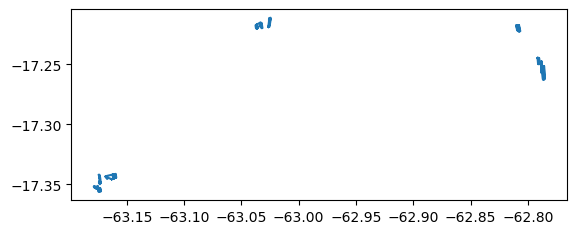

In [15]:
gdf_lines.plot()

In [16]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

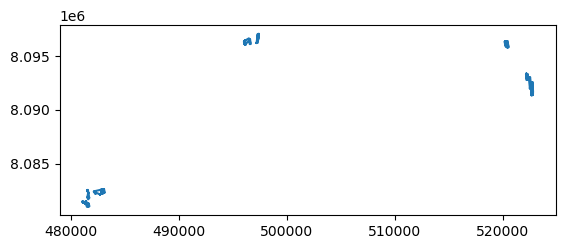

In [17]:
gdf_lines_utm.plot()

In [18]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [19]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-10-23 20-40-14.tlog,"LINESTRING (522603.111 8092330.582, 522603.111...",5,DA01,0
1,2025-10-23 22-23-06.tlog,"LINESTRING (522603.505 8092331.068, 522603.505...",3115,DA01,0
2,2025-10-23 22-23-06.tlog,"LINESTRING (522598.138 8092332.457, 522598.138...",1862,DA01,0
3,2025-10-23 22-23-06.tlog,"LINESTRING (522198.221 8093348.319, 522198.211...",1550,DA01,0
4,2025-10-23 23-58-21.tlog,"LINESTRING (520245.366 8096365.826, 520245.387...",2123,DA01,0
5,2025-10-23 23-58-59.tlog,"LINESTRING (496135.314 8096081.739, 496135.314...",63,DA01,0
6,2025-10-23 23-59-55.tlog,"LINESTRING (496136.271 8096082.458, 496136.271...",89,DA01,0
7,2025-10-24 01-28-49.tlog,"LINESTRING (496136.388 8096083.111, 496136.388...",1876,DA01,0
8,2025-10-24 01-28-49.tlog,"LINESTRING (497178.023 8096210.015, 497178.033...",1752,DA01,0
9,2025-10-24 01-53-59.tlog,"LINESTRING (481477.466 8081339.325, 481477.477...",2832,DA01,0


In [20]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)